## Задание 4: визуализация многомерных данных 
- Срок сдачи: до 12 мая включительно. 
- Реализуйте один из алгоритмов LLE, IsoMap, **t-SNE** для визуализации многомерных данных. 
- Входные данные на Ваш выбор. Возьмите тот датасет, который лично Вам интересен и для которого реально видно, что алгоритм выдаёт разумное расположение. 
- В качестве бонуса можно реализовать Hessian LLE или UMAP. 

### Мною был выбран t-SNE.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Источники 
# - https://cs.nyu.edu/~roweis/papers/sne_final.pdf
# - http://www.cs.toronto.edu/~hinton/absps/tsne.pdf

PERPLEXITY=5
g_kernel=1
EPOCHS=2000
LR=200
MOMENTUM=0.99


def getKey(item):
    return item[1]


def k_neighbours(x,x1_index,p_or_q='p'):
    x1=x[x1_index]
    list_k_neighbours=[]
    for i in range(x.shape[0]):
        if i!=x1_index:
            xi=x[i]
            if p_or_q=='p':
                distance=np.exp(-np.linalg.norm(x1-xi)**2/(2*g_kernel**2))
            else:
                distance=(1+np.linalg.norm(x1-xi)**2)**-1
            list_k_neighbours.append([i,distance])
    
    list_k_neighbours=sorted(list_k_neighbours,key=getKey)
    return list_k_neighbours[:PERPLEXITY]


def compute_pij(x,x1_index,x2_index):
    x1=x[x1_index]
    x2=x[x2_index]
    num=np.exp(-np.linalg.norm(x1-x2)**2)/(2*g_kernel**2)
    denom=0
    list_k_neighbours=k_neighbours(x,x1_index,'p')
    for i in list_k_neighbours:
        denom+=i[1]
    return num/denom


def compute_p(x):
    table=np.zeros((x.shape[0],x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            if i!=j:
                pij=compute_pij(x,i,j)
                pji=compute_pij(x,j,i)
                table[i,j]=(pij+pji)/(2*x.shape[0])
    return table


def compute_qij(y,y1_index,y2_index):
    y1=y[y1_index]
    y2=y[y2_index]
    num=(1+np.linalg.norm(y1-y2)**2)**(-1)
    denom=0
    for i in k_neighbours(y,y1_index,'q'):
        denom+=i[1]
    return num/denom


def compute_q(y):
    table=np.zeros((y.shape[0],y.shape[0]))
    for i in range(y.shape[0]):
        for j in range(y.shape[0]):
            if i!=j:
                qij=compute_qij(y,i,j)
                table[i,j]=qij
    return table


def kl_divergence(p,q):
    total=0
    for i in range(p.shape[0]):
        for j in range(q.shape[0]):
            if q[i,j]!=0 and p[i,j]!=0:
                total+=p[i,j]*np.log(p[i,j]/q[i,j])
    return total


def gradient_descent(p,q,y):
    history=np.zeros((p.shape[0],2,y.shape[1]))
    for iter in range(EPOCHS):
        for i in range(y.shape[0]):
            sum_value=0
            for j in range(y.shape[0]):
                sum_value+=((y[i]-y[j])*(p[i,j]-q[i,j])*(1+np.linalg.norm(y[i]-y[j]**2))**-1)
            y[i]-=4*LR*sum_value+MOMENTUM*(history[i,1]-history[i,0])
            history[i,0]=history[i,1]
            history[i,1]=y[i]
        if iter%100==0:
            q=compute_q(y)
            print('divergence', kl_divergence(p,q)) 
    y-=np.mean(y)
    y/=np.std(y)
    return y

### Генерация датасета

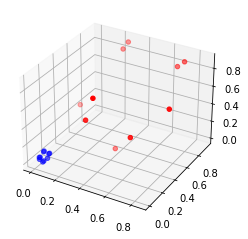

In [18]:
x=np.random.rand(10,3)
x=np.tile(x,(2,1))
x[:10]*=0.1
color=['blue']*10+['red']*10
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2],color=color)
plt.show()

### t-NSE

divergence -13.484418379262106
divergence -16.803401698583286
divergence -12.654906328641205
divergence -12.333339287741298
divergence -12.365559680289195
divergence -12.39258485681447
divergence -12.416700700076415
divergence -12.438681171683044
divergence -12.461568796983228
divergence -12.483681334490933
divergence -12.50441303673024
divergence -12.523932249766865
divergence -12.544167983254079
divergence -12.56372414254238
divergence -12.582395785895466
divergence -12.600266162118167
divergence -12.618389100858412
divergence -12.636904874638981
divergence -12.656170020618484
divergence -12.674841881363728


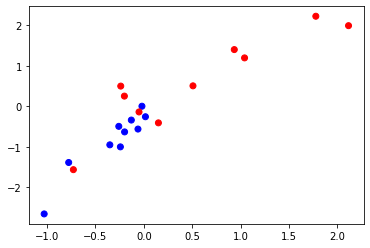

In [19]:
table_p=compute_p(x)
#Probably not the right way to initialize the new space y
y=x.dot(np.random.rand(x.shape[1],2))
y-=np.mean(y)
y/=np.std(y)
table_q=compute_q(y)
y=gradient_descent(table_p,table_q,y)
plt.scatter(y[:,0],y[:,1],color=color)
plt.show()